We will use this tutorial to generate Synhtetic microstructures using hte voronoi tesellation method and then perform DAMASK crystal plasticity simulations for uniaxial tensile test.

**Microstructure Generation**

We use a multi-level Voronoi tessellation to create synthetic 2D DP steel microstructures discretized by a $128\times128$ regular grid of physical size $1\times1$ a.u.
In the first step, we create a grain structure by periodic tessellation of $n_1 = [20\,..\,60]$ seeds placed randomly in a $256\times128$ grid with physical size $2 \times 1$ a.u.
Each grain gets a randomly selected crystallographic orientation assigned.
Next, we place $n_2 = [10\,..\,40]$ seeds and perform a second level tessellation.
The second level seed determines the phase of all grains whose first level seed is closest.
Finally, we discard every second layer along the first direction to arrive at a $128\times128$ regular grid of physical size $1\times 1$ a.u. to obtain elongated grains.
In total, we created  15,000 microstructures with a martensite fraction between 10-80\%.
While the generated microstructures are an idealized representation of reality, they contain many characteristic features of DP steels:
clustering of grains of the same phase, phase regions of concave shape, and grains with an elongated shape.

In this tutorail we will generate one such microstructure

**Crystal Plasticity simulations:**

**Material properties:**

The mechanical response of the  2D DP steel microstructures is predicted with full-field crystal plasticity simulations using the spectral solver from the open-source multi-physics package DAMASK. The constitutive response of martensite and ferrite phases are modeled using the phenomenological crystal plasticity model for body-centered cubic (bcc) crystals


The constitutive parameters for martensite and ferrite phase shown in the table are adopted from [1].These parameters have been identified from nano-indentation experiments on a DP steel with a yield strength of approximately 600 MPa.


[1]Tasan C., Hoefnagels J., Diehl M., Yan D., Roters F., Raabe D.
Strain localization and damage in dual phase steels investigated by coupled in-situ deformation experiments and crystal plasticity simulations
Int. J. Plast., 63 (2014), pp. 198-210, 10.1016/j.ijplas.2014.06.004

<table>
    <caption>Constitutive parameters of martensite and ferrite phase used for crystal plasticity simulations adopted from Tasan et al. (2014).</caption>
    <tr>
        <th>Property</th>
        <th>Symbol</th>
        <th>Ferrite</th>
        <th>Martensite</th>
        <th>Unit</th>
    </tr>
    <tr>
        <td>Elastic constant</td>
        <td>C<sub>11</sub></td>
        <td>233.3</td>
        <td>417.4</td>
        <td>GPa</td>
    </tr>
    <tr>
        <td>Elastic constant</td>
        <td>C<sub>12</sub></td>
        <td>135.5</td>
        <td>242.4</td>
        <td>GPa</td>
    </tr>
    <tr>
        <td>Elastic constant</td>
        <td>C<sub>44</sub></td>
        <td>118.0</td>
        <td>211.1</td>
        <td>GPa</td>
    </tr>
    <tr>
        <td>Initial resistance</td>
        <td>&#958;<sub>0,{110}</sub></td>
        <td>95</td>
        <td>406</td>
        <td>MPa</td>
    </tr>
    <tr>
        <td>Saturation resistance</td>
        <td>&#958;<sub>&infin;,{110}</sub></td>
        <td>222</td>
        <td>873</td>
        <td>MPa</td>
    </tr>
    <tr>
        <td>Initial resistance</td>
        <td>&#958;<sub>0,{112}</sub></td>
        <td>97</td>
        <td>457</td>
        <td>MPa</td>
    </tr>
    <tr>
        <td>Saturation resistance</td>
        <td>&#958;<sub>&infin;,{112}</sub></td>
        <td>412</td>
        <td>971</td>
        <td>MPa</td>
    </tr>
    <tr>
        <td>Initial hardening rate</td>
        <td>h<sub>0</sub></td>
        <td>1</td>
        <td>563</td>
        <td>GPa</td>
    </tr>
    <tr>
        <td>Interaction parameter</td>
        <td>h<sub>&alpha;&beta;</sub></td>
        <td>1</td>
        <td>1</td>
        <td></td>
    </tr>
    <tr>
        <td>Reference shear rate</td>
        <td>&#947;<sub>0</sub></td>
        <td>1</td>
        <td>1</td>
        <td>1e-3 s<sup>-1</sup></td>
    </tr>
    <tr>
        <td>Stress exponent</td>
        <td>n</td>
        <td>20</td>
        <td>20</td>
        <td></td>
    </tr>
    <tr>
        <td>Strain hardening exponent</td>
        <td>a</td>
        <td>2.0</td>
        <td>2.0</td>
        <td></td>
    </tr>
</table>


**Load**

To assess their mechanical response, we use crystal plasticity simulations from DAMASK and perform uniaxial tensile tests into a global strain of 7%

**Main Steps**:

- **Microstructure Generation**: `material.YAML` , `geometry.Vti`
    1. Generate seeds from Random
    2. Use voronoi Tesellation to generate microstructure
    3. Assign phases to the seeds randomly
    4. USe material properties for Martensite and Ferrite from '*Tasan2016* '
    
    
- **Prepare for simulation**: `tensionX.YAML`, `numerics.YAML`
    1. prepare load file 
    2. prepare numerics file
    
- **Run DAMASK simulation**: `_tensionX.hdf5`
    1. Set number of threads for simulation 
    2. Create a separate log file to store the data
 
- **Post processing to add data only for last increment**: `_tensionX_inc230.Vti`
    1. Add Von mises stress and strain
    2. Add Brittle damage indicator (maximum principal stress - Rankie damage indicator)
    3. Add ductile damage indicator (plastic strain energy)
    
- **Extract data as numpy array and Visualize data**: 
    1. Phase data
    2. Orientation data from initial increment
        - Quaternnoin
        - Euler
    3. Yield stress
    4. Von Mises stress strain
    5. Damage : Brittle, Ductile

# A. Practice with simple Example

## 1. Create Microstructure and config Files

In [2]:
import damask
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### a. Generate seeds 

In [3]:
# Generate seeds
size = np.ones(3)*1   # Physical size of the seeding domain
N_grains = 4              # Number of seeds
cells = [10,10,1]         # Grid resolution we want


seeds = damask.seeds.from_random(size,N_grains, cells)
print("Seed coordinates in 3D space: \n", seeds)

Seed coordinates in 3D space: 
 [[0.43216365 0.06717874 0.29373469]
 [0.63693411 0.92562363 0.73182991]
 [0.03519469 0.95795274 0.25273176]
 [0.16229174 0.55018323 0.41707363]]


### b. Create geometry file
`.Vti`

In [4]:
# Generate Grid-based geometry from Voronoi Tessellation
grid = damask.Grid.from_Voronoi_tessellation(cells,size,seeds,material=None,periodic=True)
print("Grid-based geometry from tessellation \n", grid)

Grid-based geometry from tessellation 
 cells : 10 x 10 x 1
size  : 1.0 x 1.0 x 1.0 / m³
origin: 0.0   0.0   0.0 / m
# materials: 4


In [5]:
grid.material.shape

(10, 10, 1)

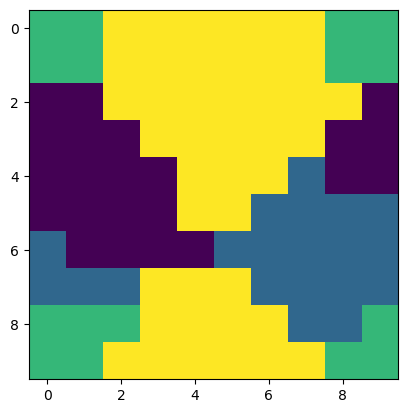

In [6]:
plt.imshow(grid.material.reshape(10,10))

In [7]:
# save the grid data as vtk file that is input to the DAMASK
grid.save(fname = f'Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}')

### c. Material config file
`material.YAML` 

**create the MAterial confg file and assign the orientation and phase data**

  Manipulate material configurations for storage in YAML format.
    A complete material configuration file has the entries `material`,
    `phase`, and `homogenization`. For use in DAMASK, it needs to be
    stored as `material.yaml`.

#### c0. Initialize material config file

In [9]:
# initialize the material dictionsry
material = damask.ConfigMaterial()
material

material: []

homogenization: {}

phase: {}

#### c1. Add Homogenization

In [10]:
# define homogenization
hom = ['SX']*N_grains
hom

['SX', 'SX', 'SX', 'SX']

In [11]:
# update homogenization data
material.update({"homogenization":{"SX":{"N_constituents":1,
                                          "mechanical": {"type": "pass"}}}})
material

material: []

homogenization:
  SX:
    N_constituents: 1
    mechanical: {type: pass}

phase: {}

#### c2. Phases

In [12]:
# Define Phase for each seed
phases = ['Ferrite','Martensite','Martensite','Ferrite']
phases

['Ferrite', 'Martensite', 'Martensite', 'Ferrite']

In [13]:
# extract martensite material properties
phase_data = damask.ConfigMaterial.load('config/phase.yaml')

In [14]:
# Update phase properties
material.update({"phase": phase_data})
material

material: []

homogenization:
  SX:
    N_constituents: 1
    mechanical: {type: pass}

phase:
  Ferrite:
    lattice: cI
    mechanical:
      output: [F, F_e, F_p, P, L_p, O]
      elastic: {C_11: 233.3e9, C_12: 135.5e9, C_44: 118.0e9, type: Hooke}
      plastic:
        output: [xi_sl, gamma_sl]
        N_sl: [12, 12]
        a_sl: 2.0
        dot_gamma_0_sl: 0.001
        h_0_sl-sl: 1000.0e6
        h_sl-sl: [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
        n_sl: 20
        type: phenopowerlaw
        xi_0_sl: [95.e6, 96.e6]
        xi_inf_sl: [222.e6, 412.7e6]
  Martensite:
    lattice: cI
    mechanical:
      output: [F, F_e, F_p, P, L_p, O]
      elastic: {C_11: 417.4e9, C_12: 242.4e9, C_44: 211.1e9, type: Hooke}
      plastic:
        output: [xi_sl, gamma_sl]
        N_sl: [12, 12]
        a_sl: 2.0
        dot_gamma_0_sl: 0.001
        h_0_sl-sl: 563.0e9
        h_sl-sl: [1, 1.4, 1, 1.4, 1.4, 1.4, 1.4

#### c3. orientation

In [15]:
# Orientation data in euler angles for each seed
Ori = damask.Rotation.from_random(N_grains).as_quaternion()  # remember to give orientations only in Quaternion
Ori

array([[ 0.2679559 ,  0.07671538, -0.5983353 ,  0.7512052 ],
       [ 0.37535202, -0.87171274,  0.29629051,  0.10695652],
       [ 0.12963743,  0.47325747,  0.80072138,  0.34360846],
       [ 0.87076817, -0.11062096,  0.47783655,  0.03461253]])

#### c4. Update the Data for material file 

In [16]:
# add the data to the dictionary
material = material.material_add(phase=phases,
                                  O = Ori,
                                  homogenization = hom)
material

material:
  - constituents:
      - phase: Ferrite
        O: [0.26795589888367505, 0.07671538384878827, -0.5983353021501263, 0.7512051998856849]
        v: 1.0
    homogenization: SX
  - constituents:
      - phase: Martensite
        O: [0.37535202083439684, -0.8717127390180894, 0.29629050572760846, 0.10695652062774297]
        v: 1.0
    homogenization: SX
  - constituents:
      - phase: Martensite
        O: [0.12963743352448506, 0.473257469321091, 0.8007213823640915, 0.34360845651106975]
        v: 1.0
    homogenization: SX
  - constituents:
      - phase: Ferrite
        O: [0.8707681701160697, -0.11062095699672536, 0.4778365518740182, 0.034612533553451945]
        v: 1.0
    homogenization: SX

homogenization:
  SX:
    N_constituents: 1
    mechanical: {type: pass}

phase:
  Ferrite:
    lattice: cI
    mechanical:
      output: [F, F_e, F_p, P, L_p, O]
      elastic: {C_11: 233.3e9, C_12: 135.5e9, C_44: 118.0e9, type: Hooke}
      plastic:
        output: [xi_sl, gamma_sl]
 

In [17]:
print(f'configuration is{" " if material.is_valid else " not "}valid\n')


configuration is valid



#### c5. Save  
`material.YAML file`

In [18]:
# save your data to the final material file for DAMASK
material.save(fname='material.yaml')

### d. Load File 
`tensionX.YAML`

### e. Numerics file
`numerics.YAML`

## 2. Run Simulation
`_tensionX.hdf5`

In [ ]:
!DAMASK_grid -g Polycystal_4_10x10x1.vti -l config/tensionX.yaml -n config/numerics.yaml >logFile.txt

## 3. Postprocessing Results

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

#### load data

In [ ]:
result = damask.Result("Polycystal_4_10x10x1_tensionX.hdf5")

#### Add data

In [ ]:
#Select data only from last increment
r = result.view('increments',230)

In [ ]:
r

In [ ]:
#add cauchy stress                              
r.add_stress_Cauchy()                                               # sigma 
# add von mises of cauchy Stress                 
r.add_equivalent_Mises('sigma')                                     # sigma_vM
# add Strain tensor                       
r.add_strain(F='F', t='V')                                          # epsilon_V^0.0(F)
# add Von Mises for strain
r.add_equivalent_Mises('epsilon_V^0.0(F)')                          # epsilon_V^0.0(F)_vM
#add plastic strain tensor
r.add_strain(F='F_p', t='U')                                        # epsilon_U^0.0(F_p)
# add vonvmises for plastic strain tensor
r.add_equivalent_Mises('epsilon_U^0.0(F_p)')                        # epsilon_U^0.0(F_p)_vM
# add hydrostatic stress 
r.add_spherical('sigma')                                            # p_sigma 
# add ductile damage indicator
duc_dam_f='#epsilon_U^0.0(F_p)_vM#*0.5*(#p_sigma#+np.abs(#p_sigma#))'
r.add_calculation(
        formula=duc_dam_f,
        name='duc_damage',
        unit='N/m^2', 
        description='Ductile Damage indicator')                    # duc_damage
# add the brittle damage indicator 
# (maximum principal stress - Rankie damage indicator)
r.add_eigenvalue('sigma',eigenvalue='max')                         # lambda_max(sigma)

r

## 4. Visualize data

In [ ]:
from scipy import interpolate

In [ ]:
def extract_picolastress_P1_converged(log_file):
    
    """
    Extracts P11,F11
    
    P11:  first component of Piola--Kirchhoff stress (Mpa)from a given DAMASK log file and
    F11: first component of deformation gradient
    
    Args:***
    ------------
    log_file: DAMASK simulation log file
    
    """
    data = open(log_file,"r")
    all_lines = data.read()
    test_str   = all_lines
    regex = r" \#.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n*\n.............."

    matches = re.finditer(regex, test_str, re.MULTILINE)
    new_lines = []
    for matchNum, match in enumerate(matches, start=1):
        new_lines.append(match.group())


    stress = []
    for l in new_lines[2:]:   # changing the appendix according tothe new DAMASK version

        pattern_1 = "Piola.*\n.............."
        a = re.findall(pattern_1,l)

        pattern_2 = "[0-9].*\....."
        b = float(re.findall(pattern_2, a[0])[0])

        stress.append(b)
        
    
    deformation = []
    for l in new_lines[2:]:   # changing the appendix according tothe new DAMASK version

        pattern_1 = "deformation gradient aim.*\n............"
        a = re.findall(pattern_1,l)

        pattern_2 = "[0-9].*\........"
        b = float(re.findall(pattern_2, a[0])[0])

        deformation.append(b)
    
    return stress, deformation

In [ ]:
def yield_stress_strain(F11,P11,strain_pl,plot_graph=False):
    
    '''
    calculates the yield stress for a given stress strain data points 
    of single microstructure
    
    Args**
            1. F11: avg deformation for all load increments
            2. P11: avg first picola kirchoff stress for all increments
            3. Strain_pl: plastic strain at which the yield occurs
    
    returns**
            1. yield Stress corresponding to the given plastic strain
            2. strain at yield stress
            
            Steps

            1. Get the discrete stress strain data points of a single microstructure
            2. Fit the stress strain points to a curve using the univarientSpline
            3. Take linear samples of strain ($\varepsilon_{re}$) and get the corresponding
                fitting values of stress ($\sigma_{re}$)
            4. define the plastic strain at which the yielding occurs ($\varepsilon_{pl}$)
            5. we need to look for the first point in the list where the following value 
            is positive,the stress at the corresponding point is yield stress

              $$ (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} $$

              $$ \sigma_{yield} = \sigma(where ( (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} )> 0 )$$
            
    '''
    
    strain = np.array(F11) - 1.0
    stress = P11
    E = stress[1]/strain[1] # stiffness
    strain_pl = strain_pl       # plastic strain

    #### curve fitting with spline
    stress_strain_spl = interpolate.UnivariateSpline(strain[1:], stress[1:],s=50)   # ignore the first data point 
    strain_re = np.linspace(strain[0],strain[-1],1000)                              #  linear sampled new strain 
    stress_re = stress_strain_spl(strain_re)                                      # get sampled stress

    # get yield stress 
    yield_stress_idx = np.argmax(((strain_re-strain_pl)*E - stress_re)>0)    # first point where he value is poisitive
    yield_Stress     = stress_re[yield_stress_idx]
    strain_at_yield  = strain_re[yield_stress_idx]
    
    if plot_graph==True:
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=strain_re, y=stress_re,
            name='stress_re',
            mode='markers',
            marker_color='rgba(0, 0, 0, .8)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re)*E,
            name='(strain_re)*E',
            marker_color='rgba(255, 255, 0, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re-strain_pl)*E,
            name='(strain_re-strain_pl)*E',
            marker_color='rgba(0, 255, 255, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=((strain_re-strain_pl)*E - stress_re),
            name='((strain_re-strain_pl)*E - stress_re)',
            marker_color='rgba(0, 0, 193, .9)'
        ))

        fig.add_trace(go.Scatter(
            x=[strain_at_yield,strain_at_yield], y=[yield_Stress,yield_Stress],
            name='yield_Stress',
            marker_size=20.0
        ))
        
        fig.update_layout(yaxis_range=[-20,1000.0],
                         title="Loading curve",
                         xaxis_title="F11",
                         yaxis_title="P11 (Mpa)",)
        
        fig.show()
    
    return yield_Stress, strain_at_yield

### Phase data

In [ ]:
print(r.phase.shape)
r.phase

In [ ]:
# assign '0' to martensite and '1' to ferrite 
phases = np.array(r.phase== 'Ferrite', dtype="uint8").reshape(10,10)
phases

In [ ]:
# plot
plt.imshow(phases)
plt.colorbar()
plt.title("Phase data")
plt.show()

### Orientation

In [ ]:
#Select data only from initial increment: Just to get the Initial orientation information
r = result.view('increments',0)
# get initial orientation of Quaternions
O_qu = r.place()["phase"]['O'].data
# set the r back to last increment for further calculations
r = result.view('increments',230)

print(O_qu.shape)
O_qu

In [ ]:
# plot orientations: Quternion
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title("q_w")
plt.imshow(O_qu[:,0].reshape(10,10))
plt.subplot(1,4,2)
plt.title("q_x")
plt.imshow(O_qu[:,1].reshape(10,10))
plt.subplot(1,4,3)
plt.title("q_y")
plt.imshow(O_qu[:,2].reshape(10,10))
plt.subplot(1,4,4)
plt.title("q_z")
plt.imshow(O_qu[:,3].reshape(10,10))
plt.show()

In [ ]:
# convert rotations to Euler angles (Degree)
O_eu = damask.Rotation.from_quaternion(O_qu).as_Euler_angles(degrees=True)
O_eu

In [ ]:
# plot orientations: euler
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("phi_1")
plt.imshow(O_eu[:,0].reshape(10,10))
plt.subplot(1,3,2)
plt.title("Phi")
plt.imshow(O_eu[:,1].reshape(10,10))
plt.subplot(1,3,3)
plt.title("Phi_2")
plt.imshow(O_eu[:,2].reshape(10,10))
plt.show()

### Yield Stress 

#### How to calculate Yield Stress

Caculate yield stress

Steps

1. Get the discrete stress strain data points of a single microstructure
2. Fit the stress strain points to a curve using the univarientSpline
3. Take linear samples of strain ($\varepsilon_{re}$) and get the corresponding fitting values of stress ($\sigma_{re}$)
4. define the plastic strain at which the yielding occurs ($\varepsilon_{pl}$)
5. we need to look for the first point in the list where the following value is positive,the stress at the corresponding point is yield stress


  $$ (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} $$
  
  
  $$ \sigma_{yield} = \sigma(where ( (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} )> 0 )$$

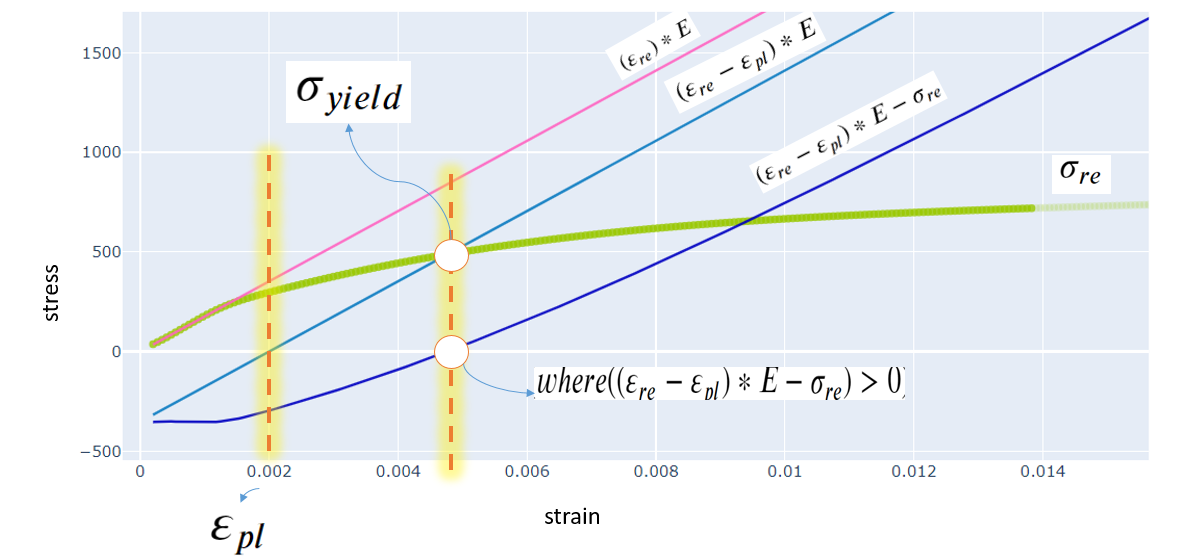

#### Simple example

In [ ]:
#  Extract the stress strain data
P11,F11 = extract_picolastress_P1_converged("sample.txt")

In [ ]:
# get Yield stress and plot Loading curve
yield_stress, yield_strain = yield_stress_strain(F11,P11,strain_pl=0.003,plot_graph=True)
print("Yield stress: ", yield_stress)

### Von Mises

In [ ]:
VM_stress = r.place()['phase']['sigma_vM'].data
VM_strain = r.place()['phase']['epsilon_V^0.0(F)_vM'].data
VM_stress.shape, VM_strain.shape

In [ ]:
# plot
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(VM_stress.reshape(10,10))
plt.title("Von Mises Stress")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(VM_strain.reshape(10,10))
plt.title("Von Mises Strain")
plt.colorbar()
plt.show()

### Damage

In [ ]:
brit = r.place()['phase']['lambda_max(sigma)'].data
duct = r.place()['phase']['duc_damage'].data
brit.shape, duct.shape

In [ ]:
# plot
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(brit.reshape(10,10))
plt.title("brittle damage vatrable")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(duct.reshape(10,10))
plt.title("Duct damage vatrable")
plt.colorbar()
plt.show()

# B. Creating functions to do the above Job

In [19]:
import damask
import numpy as np
%pylab inline
from scipy import interpolate
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_seeds(N_grains,cells):
    
    '''
    Creates seeds from random
    **Args
            N_grains: No of seeds,  int
            cells: grid resolution, [int,int,int]
    **returns:
           seed coordinates 
           
    **Example
    N_grains = 4              # Number of seeds
    cells = [10,10,1]         # Grid resolution we want
    
    '''
    # Generate seeds
    size = np.ones(3)*1   # Physical size of the seeding domain
    

    seeds = damask.seeds.from_random(size,N_grains, cells)
    #print("Seed coordinates in 3D space: \n", seeds)
    return seeds

In [3]:
def create_grid(cells,seeds):
    '''
    Generate Grid-based geometry from Voronoi Tessellation and save
    
    **Args
            seeds: seeds array (..., 3)
            cells: grid resolution, [int,int,int]
    **returns:
           seed coordinates 
    '''
    size = np.ones(3)*1   # Physical size of the seeding domain
    
    # Generate Grid-based geometry from Voronoi Tessellation
    grid = damask.Grid.from_Voronoi_tessellation(cells=cells,
                                                 size=size,
                                                 seeds=seeds,
                                                 material=None,
                                                 periodic=True)
    #print("Grid-based geometry from tessellation \n", grid)
    
    # save the grid data as vtk file that is input to the DAMASK
    grid.save(fname = f'Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}')

In [4]:
def create_Material_config(N_grains):
    '''
    create material configurations and stored as material.yaml. 
    A complete material configuration file has the entries
    - homogenization
    - material: material point data i.e texture and phase distribution
    - phase: details about the phase properties and plasticity parameters
    
    **Args
        N_grains: No of seeds
    '''
    ## 0. Initialize material config file
    # initialize the material dictionsry
    material = damask.ConfigMaterial()
    
    ## 1. Add Homogenization
    # define homogenization
    hom = ['SX']*N_grains
    # update homogenization data
    material.update({"homogenization":{"SX":{"N_constituents":1,
                                             "mechanical": {"type": "pass"}}}})
    
    ## 2. Phase distribution data
    # define phase names
    phase_names = ["Ferrite", "Martensite"]
    # create random numbers btw 0 and 1
    seeds_phases = np.random.randint(low=0, high=2, size=(N_grains,))
    # assign phases to the seeds according to the above random assignment
    phases_list = [phase_names[i] for i in seeds_phases]
    
    # extract martensite material properties
    phase_data = damask.ConfigMaterial.load('config/phase.yaml')
    # Update phase properties
    material.update({"phase": phase_data})
    
    ## 3. Orientation
    # Orientation data in euler angles for each seed
    Ori = damask.Rotation.from_random(N_grains).as_quaternion()  # remember to give orientations only in Quaternion
    
    ## 4. Update and save Data for material file
    # add the data to the dictionary
    material = material.material_add(phase=phases_list,O = Ori,homogenization = hom)
    # save your data to the final material file for DAMASK
    material.save(fname='material.yaml')

In [5]:
def create_microstructure(N_grains,cells):
    '''
    Creates the geometry file and material config file that is required for DAMASK simulation
    '''
    # create seeds
    seeds = create_seeds(N_grains,cells)
    
    # create grid i.e geometry file
    create_grid(cells,seeds)
    
    # create materuial.YAML file
    create_Material_config(N_grains)
    
    print("Created microstructure and material")

In [6]:
def run_DAMASK():
    
    # prepare load file
    
    # prepare numerics file
    
    # run DAMASK and save config file
    return()

In [7]:
def post_processing(result_file):
    """
    It Edits the given .HDF5 file to add the Von mises stress and 
    Damage parameter values only to the increment 230
    """
    ##1. load data
    result = damask.Result(result_file)
    
    ## 2. Add data
    # add IPF
    r = result.view('increments',0)
    r.add_IPF_color(l=np.array([0,0,1]))
    
    r.view_less('increments',0)
    #Select data only from last increment
    r = result.view('increments',230)
    #add cauchy stress                              
    r.add_stress_Cauchy()                                               # sigma 
    # add von mises of cauchy Stress                 
    r.add_equivalent_Mises('sigma')                                     # sigma_vM
    # add Strain tensor                       
    r.add_strain(F='F', t='V')                                          # epsilon_V^0.0(F)
    # add Von Mises for strain
    r.add_equivalent_Mises('epsilon_V^0.0(F)')                          # epsilon_V^0.0(F)_vM
    #add plastic strain tensor
    r.add_strain(F='F_p', t='U')                                        # epsilon_U^0.0(F_p)
    # add vonvmises for plastic strain tensor
    r.add_equivalent_Mises('epsilon_U^0.0(F_p)')                        # epsilon_U^0.0(F_p)_vM
    # add hydrostatic stress 
    r.add_spherical('sigma')                                            # p_sigma 
    # add ductile damage indicator
    duc_dam_f='#epsilon_U^0.0(F_p)_vM#*0.5*(#p_sigma#+np.abs(#p_sigma#))'
    r.add_calculation(
            formula=duc_dam_f,
            name='duc_damage',
            unit='N/m^2', 
            description='Ductile Damage indicator')                    # duc_damage
    # add the brittle damage indicator 
    # (maximum principal stress - Rankie damage indicator)
    r.add_eigenvalue('sigma',eigenvalue='max')                         # lambda_max(sigma)

In [8]:
def extract_data(result_file,log_file):
    """
    
    """
    ## 1.Load data 
    # extract data from HDF5 file
    result = damask.Result(result_file)
    #Select data only from last increment
    r = result.view('increments',230)
    
    ## 2. Phase data
    # assign '0' to martensite and '1' to ferrite 
    phases = np.array(r.phase== 'Ferrite', dtype="uint8").reshape(10,10)
    
    
    ## 3. Orientation
    #Select data only from initial increment: Just to get the Initial orientation information
    r = result.view('increments',0)
    # get initial orientation of Quaternions
    O_qu = r.place()["phase"]['O'].data
    # convert rotations to Euler angles (Degree)
    O_eu = damask.Rotation.from_quaternion(O_qu).as_Euler_angles(degrees=True)
    ## IPF
    IPF = r.place()['phase']['IPFcolor_(0 0 1)'].data
    # set the r back to last increment for further calculations
    r = result.view('increments',230)
    
    ## 4. Yield stress
    #  Extract the stress strain data fro all increments from log file 
    P11,F11 = extract_picolastress_P1_converged(log_file)
    # get Yield stress and plot Loading curve
    yield_stress, yield_strain = yield_stress_strain(F11,P11,strain_pl=0.003,plot_graph=False)
    
    ## 5. Von Mises
    VM_stress = r.place()['phase']['sigma_vM'].data
    VM_strain = r.place()['phase']['epsilon_V^0.0(F)_vM'].data
    
    ## 6. Damage data
    brit_damage = r.place()['phase']['lambda_max(sigma)'].data
    duct_damage = r.place()['phase']['duc_damage'].data
    

    
    return phases,O_qu,O_eu,F11,P11,VM_stress,VM_strain,brit_damage,duct_damage,yield_stress,IPF

In [9]:
def extract_picolastress_P1_converged(log_file):
    """
    Extracts P11 and F11 from a DAMASK simulation log file.

    P11: First component of Piola-Kirchhoff stress (MPa).
    F11: First component of deformation gradient.

    Args:
    log_file (str): Path to the DAMASK simulation log file.

    Returns:
    tuple: Two lists containing the stress and deformation values respectively.
    """
    # Read the log file content
    with open(log_file, "r") as file:
        all_lines = file.read()

    # Define regex to find convergence data
    regex = r"(?:.*\n){43}.*converged.*"
    matches = re.finditer(regex, all_lines, re.MULTILINE)

    # Extract lines matching the convergence pattern
    new_lines = [match.group() for match in matches]

    # Extract Piola-Kirchhoff stress values
    stress = []
    for line in new_lines:
        pattern_1 = r"Piola.*\n.............."
        a = re.findall(pattern_1, line)
        pattern_2 = r"[0-9].*\....."
        b = float(re.findall(pattern_2, a[0])[0])
        stress.append(b)

    # Generate deformation gradient values
    deformation = np.round(np.concatenate((1 + np.linspace(0, 0.01, 51)[1:], 1 + np.linspace(0.01, 0.07, 181)[1:])), 7).tolist()

    return stress, deformation


In [10]:
def yield_stress_strain(F11,P11,strain_pl,plot_graph=False):
    
    '''
    calculates the yield stress for a given stress strain data points 
    of single microstructure
    
    Args**
            1. F11: avg deformation for all load increments
            2. P11: avg first picola kirchoff stress for all increments
            3. Strain_pl: plastic strain at which the yield occurs
    
    returns**
            1. yield Stress corresponding to the given plastic strain
            2. strain at yield stress
            
            Steps

            1. Get the discrete stress strain data points of a single microstructure
            2. Fit the stress strain points to a curve using the univarientSpline
            3. Take linear samples of strain ($\varepsilon_{re}$) and get the corresponding
                fitting values of stress ($\sigma_{re}$)
            4. define the plastic strain at which the yielding occurs ($\varepsilon_{pl}$)
            5. we need to look for the first point in the list where the following value 
            is positive,the stress at the corresponding point is yield stress

              $$ (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} $$

              $$ \sigma_{yield} = \sigma(where ( (\varepsilon_{re}-\varepsilon_{pl})*E-\sigma_{re} )> 0 )$$
            
    '''
    
    strain = np.array(F11) - 1.0
    stress = P11
    E = stress[1]/strain[1] # stiffness
    strain_pl = strain_pl       # plastic strain

    #### curve fitting with spline
    stress_strain_spl = interpolate.UnivariateSpline(strain[1:], stress[1:],s=50)   # ignore the first data point 
    strain_re = np.linspace(strain[0],strain[-1],1000)                              #  linear sampled new strain 
    stress_re = stress_strain_spl(strain_re)                                      # get sampled stress

    # get yield stress 
    yield_stress_idx = np.argmax(((strain_re-strain_pl)*E - stress_re)>0)    # first point where he value is poisitive
    yield_Stress     = stress_re[yield_stress_idx]
    strain_at_yield  = strain_re[yield_stress_idx]
    
    if plot_graph==True:

    
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=strain_re, y=stress_re,
            name='stress_re',
            mode='markers',
            marker_color='rgba(0, 0, 0, .8)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re)*E,
            name='(strain_re)*E',
            marker_color='rgba(255, 255, 0, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=(strain_re-strain_pl)*E,
            name='(strain_re-strain_pl)*E',
            marker_color='rgba(0, 255, 255, .9)'
        ))
        fig.add_trace(go.Scatter(
            x=strain_re, y=((strain_re-strain_pl)*E - stress_re),
            name='((strain_re-strain_pl)*E - stress_re)',
            marker_color='rgba(0, 0, 193, .9)'
        ))

        fig.add_trace(go.Scatter(
            x=[strain_at_yield,strain_at_yield], y=[yield_Stress,yield_Stress],
            name='yield_Stress',
            marker_size=20.0
        ))
        
        fig.update_layout(yaxis_range=[-20,1000.0],
                         title="Loading curve",
                         xaxis_title="F11",
                         yaxis_title="P11 (Mpa)",)
        
        fig.show()
    
    return yield_Stress, strain_at_yield

In [11]:
def Visualize_results(phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,yield_stress,IPF)  :
    """
    Visualize all data
    1. Microstructure
    2. Loading curve
    3. MEchanical responce
    """
    # plot phase
    plt.imshow(phases,'gray')
    plt.colorbar()
    plt.title("Phase data")
    plt.show()
    
    # plot orientations: Quternion
    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.title("q_w")
    plt.imshow(O_qu[:,0].reshape(10,10))
    plt.subplot(1,4,2)
    plt.title("q_x")
    plt.imshow(O_qu[:,1].reshape(10,10))
    plt.subplot(1,4,3)
    plt.title("q_y")
    plt.imshow(O_qu[:,2].reshape(10,10))
    plt.subplot(1,4,4)
    plt.title("q_z")
    plt.imshow(O_qu[:,3].reshape(10,10))
    plt.show()
    
    # plot orientations: euler
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title("phi_1")
    plt.imshow(O_eu[:,0].reshape(10,10))
    plt.subplot(1,3,2)
    plt.title("Phi")
    plt.imshow(O_eu[:,1].reshape(10,10))
    plt.subplot(1,3,3)
    plt.title("Phi_2")
    plt.imshow(O_eu[:,2].reshape(10,10))
    plt.show()
    
    # plot Yield stress and stress_strain curve
    _,_ = yield_stress_strain(F11,P11,strain_pl=0.003,plot_graph=True)
    
    # plot Vonmises stress strain
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(VM_stress.reshape(10,10))
    plt.title("Von Mises Stress")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(VM_strain.reshape(10,10))
    plt.title("Von Mises Strain")
    plt.colorbar()
    plt.show()
    
    
    # plot damage data
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(brit_damage.reshape(10,10))
    plt.title("brittle damage vatrable")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(duct_damage.reshape(10,10))
    plt.title("Duct damage vatrable")
    plt.colorbar()
    plt.show()
    
    # plot IPF
    plt.imshow(IPF.reshape(10,10,3))
    plt.show()

In [21]:
N_grains = 4
cells = [10,10,1]
create_microstructure(N_grains,cells)

Created microstructure and material


In [22]:
!DAMASK_grid -g Navy_Polycystal_4_10x10x1.vti -l config/tensionX.yaml -n config/numerics.yaml >log_file.txt

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL IEEE_INEXACT_FLAG
STOP 0


In [23]:
result_file = f'Navy_Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}_tensionX.hdf5'
post_processing(result_file)

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


In [24]:
#result_file = f'Navy_Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}_tensionX.hdf5'
log_file = 'log_file.txt'
phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,Yld,IPF= extract_data(result_file,log_file)

In [25]:
result_file

'Navy_Polycystal_4_10x10x1_tensionX.hdf5'

In [26]:
#result_file = f'Navy_Polycystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}_tensionX.hdf5'
log_file = 'log_file.txt'
phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,Yld,IPF= extract_data(result_file,log_file)

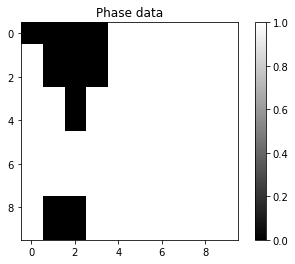

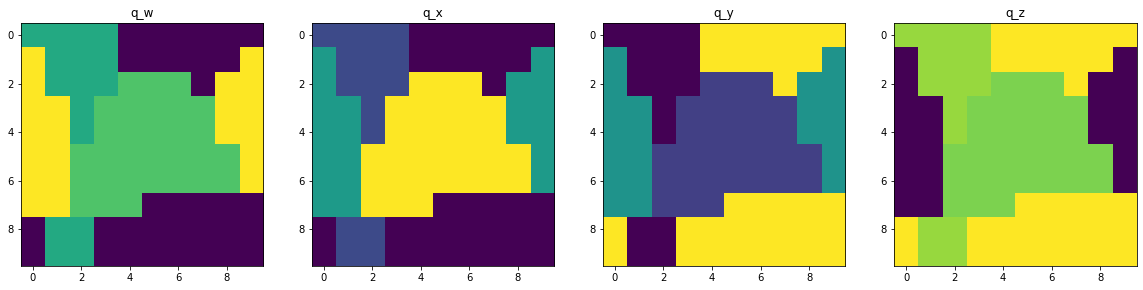

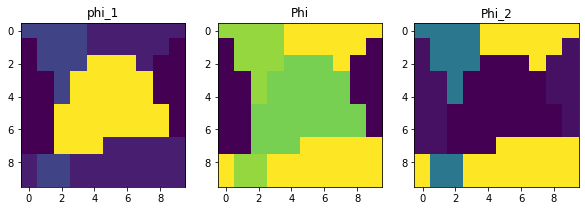

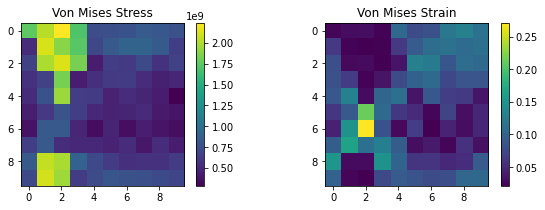

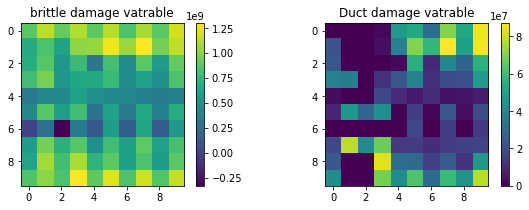

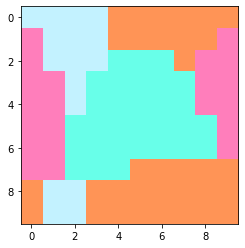

In [27]:
Visualize_results(phases, O_qu,O_eu,F11,P11, VM_stress,VM_strain,brit_damage,duct_damage,Yld,IPF)